Import libraries and installing moepy for lowess regression

In [184]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
import statsmodels.api as sm
import plotly.graph_objects as go 
from sklearn.metrics import mean_squared_error
from statsmodels.nonparametric.smoothers_lowess import lowess

In [3]:
warnings.filterwarnings("ignore")

# Reading the data with pandas

In [4]:
df = pd.read_csv("hw1.EX2.csv")
df.head(5)

,X,Y
0,84.87882,37.9
1,306.59470,42.2
2,561.98450,47.3
3,561.98450,54.8
4,390.56840,43.1


In [5]:
y = df.Y
X = df.X

Take a brief look on data visualized by scatter plot

Text(0, 0.5, 'Target y')

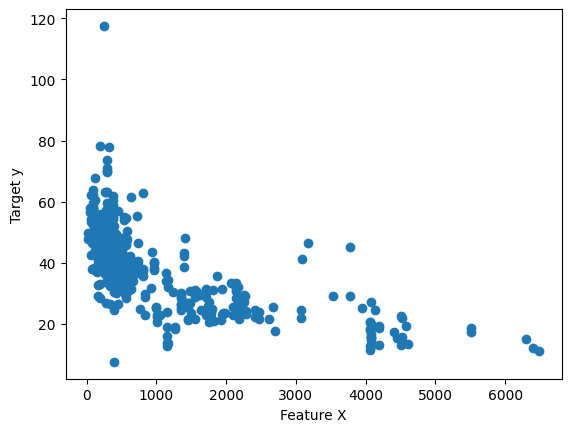

In [6]:
plt.scatter(X, y)
plt.xlabel('Feature X')
plt.ylabel('Target y')

Simple linear regression is not capable of performing any good here so some polynomial features might come in handy, but it hard to expect decent value of any quality metric

# Train dev test split for dataset

Sklearn-built function train-test-split cannot fulfill our need for splitting dataset into 3 parts, so we can use it twice to gain 3 sets of data

In [80]:
# Function for train_dev_test split
train_rate = 0.6
dev_rate = 0.2
test_rate = 0.2

def train_dev_test_split(df, train_rate=train_rate, dev_rate=dev_rate, test_rate=test_rate):
    '''
    Splits data into X_train, X_dev, X_test, y_train, y_dev, y_test
    using twice function of train_test_split
    '''
    X = df.iloc[:, :-1].values
    Y = df.iloc[:, -1].values
    X_train, X_temp, y_train, y_temp = train_test_split(X,
                                                          Y,
                                                          test_size=1.0 - train_rate,
                                                          random_state=42)
    relative_frac_test = test_rate / (dev_rate + test_rate)
    X_dev, X_test, y_dev, y_test = train_test_split(X_temp,
                                                      y_temp,
                                                      test_size=relative_frac_test,
                                                      random_state=42)

    assert len(df) == len(X_train) + len(X_dev) + len(X_test)
    # X_train, X_dev, X_test = df_train.X, df_val.X, df_test.X
    # y_train, y_dev, y_test = df_train.y, df_val.y, df_test.y
    return X_train, X_dev, X_test, y_train, y_dev, y_test


def to_df(X_train, X_dev, X_test, y_train, y_dev, y_test):
  '''
  Creates dataframes for splitted data
  '''
  df_train = pd.DataFrame(X_train, columns=['X'])
  df_dev = pd.DataFrame(X_dev, columns=['X'])
  df_test = pd.DataFrame(X_test, columns=['X'])
  df_train["Y"] = y_train
  df_dev["Y"] = y_dev
  df_test["Y"] = y_test
  return df_train, df_dev, df_test

In [81]:
X_train, X_dev, X_test, y_train, y_dev, y_test = train_dev_test_split(df)

In [83]:
df_train, df_dev, df_test = to_df(X_train, X_dev, X_test, y_train, y_dev, y_test)

# Fitting OLS with PolyFeatures, finding best degree via GridSearchCV vs loop

In assignment it was stated to fit model on test data so it has done here like this, but one could get better score by fitting on train data. We can apply GridSearch to look for best degree, but using loop is also fine as long as we does not take into account our ram

In [84]:
ols=linear_model.LinearRegression()

In [85]:
def PolynomialRegression(degree=5, **kwargs):
    '''
    Creates a pipeline of Linear Regression with poly features
    '''
    return make_pipeline(PolynomialFeatures(degree), ols)

param_grid = {'polynomialfeatures__degree': np.arange(20)}

poly_grid = GridSearchCV(PolynomialRegression(), param_grid, cv=10, scoring='neg_mean_squared_error')
poly_grid.fit(X_test.reshape(-1, 1), y_test)
print("\n The best score across ALL searched params:\n", poly_grid.best_score_)
print("\n The best parameters across ALL searched params:\n", poly_grid.best_params_)


 The best score across ALL searched params:
 -58.86016244055577

 The best parameters across ALL searched params:
 {'polynomialfeatures__degree': 4}


In [92]:
degrees = np.arange(20) 
best_score = 0
best_degree = 0
for degree in degrees:
        poly_features = PolynomialFeatures(degree = degree)
        X_train_poly = poly_features.fit_transform(X_test, y_test)
        polynomial_regressor = ols
        polynomial_regressor.fit(X_train_poly, y_test)
        scores = cross_val_score(polynomial_regressor, X_train_poly, y_test, cv=10) 
        if max(scores) > best_score:
            best_score = max(scores)
            best_degree = degree

In [231]:
print(best_degree)

5


In [90]:
poly_features = PolynomialFeatures(degree = best_degree)
X_train_poly = poly_features.fit_transform(X_dev, y_dev)
best_polynomial_regressor = ols
polynomial_regressor.fit(X_train_poly, y_dev)

LinearRegression()

Performing the same procedure but ftting on train set instead

In [107]:
poly_grid = GridSearchCV(PolynomialRegression(), param_grid, cv=10, scoring='neg_mean_squared_error')
poly_grid.fit(X_train, y_train)
print("\n The best score across ALL searched params:\n", poly_grid.best_score_)
print("\n The best parameters across ALL searched params:\n", poly_grid.best_params_)


 The best score across ALL searched params:
 -92.09771411691501

 The best parameters across ALL searched params:
 {'polynomialfeatures__degree': 4}


In [95]:
degrees = np.arange(20) 
best_score = 0
best_degree = 0
for degree in degrees:
        poly_features = PolynomialFeatures(degree = degree)
        X_train_poly = poly_features.fit_transform(X_train, y_train)
        polynomial_regressor = ols
        polynomial_regressor.fit(X_train_poly, y_train)
        scores = cross_val_score(polynomial_regressor, X_train_poly, y_train, cv=10) 
        if max(scores) > best_score:
            best_score = max(scores)
            best_degree = degree

In [230]:
print(best_degree)

5


In [97]:
poly_features = PolynomialFeatures(degree = best_degree)
X_train_poly = poly_features.fit_transform(X_dev, y_dev)
best_polynomial_regressor = ols
polynomial_regressor.fit(X_train_poly, y_dev)

LinearRegression()

# Normalization

Using normalization like $\frac{x-\mu}{\sigma} $. It is better to apply normalization on 3 datasets(train, dev, test) separately

In [167]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_dev_scaled = scaler.transform(X_dev)
X_test_scaled = scaler.transform(X_test)

# Regularizations

Adding all 3 regulatizations and noticing performance on scaled data

Ridge

In [143]:
ridge_pipe = Pipeline([
    ('pf', PolynomialFeatures(degree=5)),
    ('ridge', Ridge())])
ridge_pipe_params = {'ridge__alpha':[0.001, 0.01, 0.1, 0, 1, 10]}

In [109]:
gs_ridge_pipe = GridSearchCV(estimator=ridge_pipe, param_grid=ridge_pipe_params, cv=10, verbose=0)

gs_ridge_pipe.fit(X_train_scaled, y_train)
gs_ridge_predict = ridge_pipe.predict(X_test_scaled)
gs_ridge_pipe.best_params_

{'ridge__alpha': 10}

In [225]:
gs_ridge_predict = gs_ridge_pipe.predict(X_test_scaled)
print(f"MSE for Ridge: {mean_squared_error(gs_ridge_predict, y_test)}")

MSE for Ridge: 48.13373566536742


Best parameter for Ridge is 10

Lasso

In [221]:
lasso_pipe = Pipeline([
    ('pf', PolynomialFeatures(degree=5)),
    ('lasso', Lasso())])
lasso_pipe_params = {'lasso__alpha':[0.001, 0.01, 0.1, 0.3, 1, 2, 3, 4, 5, 6, 6.1, 8, 9, 10, 100]}

In [222]:
gs_lasso_pipe = GridSearchCV(estimator=lasso_pipe, param_grid=lasso_pipe_params, cv=5, verbose=0)

gs_lasso_pipe.fit(X_train_scaled.reshape(-1, 1), y_train)
gs_lasso_pipe.best_params_

{'lasso__alpha': 0.1}

In [226]:
gs_lasso_predict = gs_lasso_pipe.predict(X_test_scaled)
print(f"MSE for Lasso: {mean_squared_error(gs_lasso_predict, y_test)}")

MSE for Lasso: 49.88779882692656


Best parameter for alpha is 0.1

ElasticNet

In [128]:
EN_pipe = Pipeline([
    ('pf', PolynomialFeatures(degree=5)),
    ('ElasticNet', ElasticNet())])
EN_pipe_params = {'ElasticNet__alpha':[0.001, 0.01, 0.1, 0, 1, 2, 3, 4, 5, 6, 6.1, 8, 9, 10, 100], 
                     'ElasticNet__l1_ratio':[0.001, 0.01, 0.1, 0, 1, 2, 3, 4, 5, 6, 6.1, 8, 9, 10, 100]}

In [228]:
en_pipe = GridSearchCV(estimator=EN_pipe, param_grid=EN_pipe_params, cv=10, verbose=0)

en_pipe.fit(X_train_scaled.reshape(-1, 1), y_train)
en_pipe.best_params_

{'ElasticNet__alpha': 0.1, 'ElasticNet__l1_ratio': 1}

In [229]:
gs_en_predict = en_pipe.predict(X_test_scaled)
print(f"MSE for ElasticNet: {mean_squared_error(gs_en_predict, y_test)}")

MSE for ElasticNet: 49.88779882692656


So one can see that Ridge is the best among these 3

# Lowess regression

In [218]:
for frac in np.linspace(0.05, 1, 20):
    lowess_model = lowess(y_train, X_train.flatten(), frac=frac)
    lowess_pred = np.interp(X_dev.flatten(), lowess_model[:, 0], lowess_model[:, 1])
    mse = mean_squared_error(y_dev, lowess_pred)

    if mse < best_lowess_mse:
        best_lowess_mse = mse
        best_frac = frac
        best_lowess = lowess_model

print(f"Best lowess frac: {best_frac}")
print(f"Best lowess mse: {best_lowess_mse}")

Best lowess frac: 0
Best lowess mse: 77.07713360446857


In [ ]:
lowess_model

# Selecting models with best parameters

So here are models to test:

- LinearRegression with polynomial feature =5;

- Ridge regression with alpha=10 and polynomial feature =5; 

- Lowess regression with frac=0.15;


Concatenate dev+train datasets

In [202]:
new_train_X = pd.concat([pd.DataFrame(X_train_scaled, columns=["X"]), pd.DataFrame(X_dev_scaled, columns=["X"])]).values
new_train_y = pd.concat([pd.DataFrame(y_train, columns=["Y"]), pd.DataFrame(y_dev, columns=["Y"])]).values

In [207]:
model_1 = PolynomialRegression(degree=5)
model_2 = Ridge(alpha=10)
model_3 = lowess_model

In [208]:
model_1.fit(new_train_X, new_train_y)
model_1_pred = model_1.predict(X_test_scaled) 
# model_1.score(X_test_scaled, y_test)
mean_squared_error(model_1_pred, y_test)

48.39373496381753

In [209]:
model_2.fit(new_train_X, new_train_y)
model_2_pred = model_2.predict(X_test_scaled) 
# model_2.score(X_test_scaled, y_test)
mean_squared_error(model_2_pred, y_test)

61.131562157149105

In [217]:
lowess_model = lowess(y_train, X_train.flatten(), frac=0.15)
lowess_pred = np.interp(X_test.flatten(), lowess_model[:, 0], lowess_model[:, 1])
mse = mean_squared_error(y_test, lowess_pred)
mse 

42.9750469481841

So, the best estimator is Lowess regression with respect to performance on test dataset